# Laboratorium 7. (Dekompozycja spektralna)

In [17]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.linalg import eig
from scipy.linalg import lu_factor, lu_solve

MAX_ITER = 1000
EPS = 1e-10

## 1. Metody potęgowe

### 1.1. Zwykła

In [18]:
def power_method(A, max_iter=MAX_ITER, tol=EPS):
    n = A.shape[0]

    x = np.random.rand(n)
    x = x / np.max(np.abs(x))
    x_new = np.zeros(n)

    eigenvalue = 0

    for i in range(max_iter):
        x_new = A @ x

        max_abs = np.max(np.abs(x_new))
        x_new = x_new / max_abs

        if np.max(np.abs(x_new - x)) < tol:
            break

        x = x_new

    eigenvalue = max_abs
    eigenvector = x_new / np.linalg.norm(x_new)

    return eigenvalue, eigenvector, i + 1

### 1.2. Odwrócona

In [19]:
def inverse_power_method(A, sigma, max_iter=MAX_ITER, tol=EPS):
    n = A.shape[0]

    A_shifted = A - sigma * np.eye(n)

    lu, piv = lu_factor(A_shifted)

    x = np.random.rand(n)
    x = x / np.max(np.abs(x))

    eigenvalue = 0
    for i in range(max_iter):
        x_new = lu_solve((lu, piv), x)

        max_abs = np.max(np.abs(x_new))
        x_new = x_new / max_abs

        mu = 1.0 / max_abs
        eigenvalue = sigma + mu

        if np.max(np.abs(x_new - x)) < tol:
            break

        x = x_new

    eigenvector = x_new / np.linalg.norm(x_new)

    return eigenvalue, eigenvector, i + 1


### 1.3. Z ilorazem Rayleigha

In [20]:
def rayleigh_quotient_iteration(A, max_iter=MAX_ITER, tol=EPS):
    n = A.shape[0]

    x = np.random.rand(n)
    x = x / np.linalg.norm(x)

    mu = (x.T @ A @ x) / (x.T @ x)

    for i in range(max_iter):
        A_shifted = A - mu * np.eye(n)

        lu, piv = lu_factor(A_shifted)
        y = lu_solve((lu, piv), x)

        x_new = y / np.linalg.norm(y)

        mu_new = (x_new.T @ A @ x_new) / (x_new.T @ x_new)

        if np.max(np.abs(x_new - x)) < tol:
            break

        x = x_new
        mu = mu_new

    return mu, x, i + 1

## 2. Funkcja pomocnicza - porównanie metod

In [21]:
def compare_methods(A):
    results = {}

    start_time = time.time()
    lib_vals, lib_vecs = eig(A)
    lib_time = time.time() - start_time

    idx = np.argmax(np.abs(lib_vals))
    lib_val = lib_vals[idx]
    lib_vec = lib_vecs[:, idx]

    results["library"] = {
        "eigenvalue": lib_val,
        "eigenvector": lib_vec,
        "time": lib_time,
    }

    start_time = time.time()
    pm_val, pm_vec, pm_iter = power_method(A)
    pm_time = time.time() - start_time

    if np.dot(pm_vec, lib_vec) < 0:
        pm_vec = -pm_vec

    results["power_method"] = {
        "eigenvalue": pm_val,
        "eigenvector": pm_vec,
        "iterations": pm_iter,
        "time": pm_time,
        "rel_error_val": (
            abs(pm_val - lib_val) / abs(lib_val) if lib_val != 0 else abs(pm_val)
        ),
        "vec_similarity": abs(np.dot(pm_vec, lib_vec)),
    }

    sigma = lib_val * 0.95
    start_time = time.time()
    ipm_val, ipm_vec, ipm_iter = inverse_power_method(A, sigma)
    ipm_time = time.time() - start_time

    if np.dot(ipm_vec, lib_vec) < 0:
        ipm_vec = -ipm_vec

    results["inverse_power_method"] = {
        "eigenvalue": ipm_val,
        "eigenvector": ipm_vec,
        "iterations": ipm_iter,
        "time": ipm_time,
        "rel_error_val": (
            abs(ipm_val - lib_val) / abs(lib_val) if lib_val != 0 else abs(ipm_val)
        ),
        "vec_similarity": abs(np.dot(ipm_vec, lib_vec)),
    }

    start_time = time.time()
    rqi_val, rqi_vec, rqi_iter = rayleigh_quotient_iteration(A)
    rqi_time = time.time() - start_time

    if np.dot(rqi_vec, lib_vec) < 0:
        rqi_vec = -rqi_vec

    results["rayleigh_quotient"] = {
        "eigenvalue": rqi_val,
        "eigenvector": rqi_vec,
        "iterations": rqi_iter,
        "time": rqi_time,
        "rel_error_val": (
            abs(rqi_val - lib_val) / abs(lib_val) if lib_val != 0 else abs(rqi_val)
        ),
        "vec_similarity": abs(np.dot(rqi_vec, lib_vec)),
    }

    return results

## 3. Funkcja odpowiadająca za wizualizację wyników

In [22]:
def plot_benchmark(sizes, times, errors, iterations):
    methods = ["power_method", "inverse_power_method", "rayleigh_quotient", "library"]
    method_labels = [
        "Power method",
        "Inverse power method",
        "Rayleigh quotient",
        "Library (NumPy)",
    ]

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        plt.plot(
            sizes, times[method], marker=["o", "s", "^", "d"][i], label=method_labels[i]
        )

    plt.xlabel("Matrix size (n x n)")
    plt.ylabel("Execution time [s]")
    plt.title("Eigendecomposition methods - execution time comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods[:-1]):
        plt.semilogy(
            sizes, errors[method], marker=["o", "s", "^"][i], label=method_labels[i]
        )

    plt.xlabel("Matrix size (n x n)")
    plt.ylabel("Relative error")
    plt.title("Eigendecomposition methods - relative error comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods[:-1]):
        plt.plot(
            sizes, iterations[method], marker=["o", "s", "^"][i], label=method_labels[i]
        )

    plt.xlabel("Matrix size (n x n)")
    plt.ylabel("Number of iterations")
    plt.title("Eigendecomposition methods - iteration count comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 4. Wyniki


Benchmarking eigendecomposition methods for different matrix sizes:

Matrix size: 100x100
--------------------


,Matrix size,Method,Eigenvalue,Relative error,Vector similarity,Iterations,Time
0,100x100,Power Method,49.943900119831,6.119381e-12,1.000000000000,10,0.000301s
1,100x100,Inverse Power Method,49.943900120120,3.192498e-13,1.000000000000,9,0.000649s
2,100x100,Rayleigh Quotient,49.943900120136,2.845363e-16,1.000000000000,6,0.001220s
3,100x100,Library (NumPy),49.943900120136,N/A,N/A,N/A,0.011401s



Matrix size: 200x200
--------------------


,Matrix size,Method,Eigenvalue,Relative error,Vector similarity,Iterations,Time
0,200x200,Power Method,100.350559601860,7.137959e-12,1.000000000000,9,0.000300s
1,200x200,Inverse Power Method,100.350559602505,7.096183e-13,1.000000000000,9,0.001535s
2,200x200,Rayleigh Quotient,100.350559602576,7.080606e-16,1.000000000000,7,0.008008s
3,200x200,Library (NumPy),100.350559602576,N/A,N/A,N/A,0.041117s



Matrix size: 500x500
--------------------


,Matrix size,Method,Eigenvalue,Relative error,Vector similarity,Iterations,Time
0,500x500,Power Method,250.020982842666,6.908965e-12,1.000000000000,8,0.000874s
1,500x500,Inverse Power Method,250.020982844266,5.107521e-13,1.000000000000,9,0.022179s
2,500x500,Rayleigh Quotient,250.020982844393,5.683865e-16,1.000000000000,5,0.084937s
3,500x500,Library (NumPy),250.020982844393,N/A,N/A,N/A,0.203228s



Matrix size: 1000x1000
----------------------


,Matrix size,Method,Eigenvalue,Relative error,Vector similarity,Iterations,Time
0,1000x1000,Power Method,499.705132966051,2.263703e-14,1.000000000000,8,0.002242s
1,1000x1000,Inverse Power Method,499.705132965514,1.096133e-12,1.000000000000,9,0.046422s
2,1000x1000,Rayleigh Quotient,499.705132966062,2.275078e-16,1.000000000000,5,0.303641s
3,1000x1000,Library (NumPy),499.705132966062,N/A,N/A,N/A,0.710833s



Summary of all results:


,Matrix size,Method,Eigenvalue,Relative error,Vector similarity,Iterations,Time
0,100x100,Power Method,49.943900119831,6.119381e-12,1.000000000000,10,0.000301s
1,100x100,Inverse Power Method,49.943900120120,3.192498e-13,1.000000000000,9,0.000649s
2,100x100,Rayleigh Quotient,49.943900120136,2.845363e-16,1.000000000000,6,0.001220s
3,100x100,Library (NumPy),49.943900120136,N/A,N/A,N/A,0.011401s
4,200x200,Power Method,100.350559601860,7.137959e-12,1.000000000000,9,0.000300s
5,200x200,Inverse Power Method,100.350559602505,7.096183e-13,1.000000000000,9,0.001535s
6,200x200,Rayleigh Quotient,100.350559602576,7.080606e-16,1.000000000000,7,0.008008s
7,200x200,Library (NumPy),100.350559602576,N/A,N/A,N/A,0.041117s
8,500x500,Power Method,250.020982842666,6.908965e-12,1.000000000000,8,0.000874s
9,500x500,Inverse Power Method,250.020982844266,5.107521e-13,1.000000000000,9,0.022179s


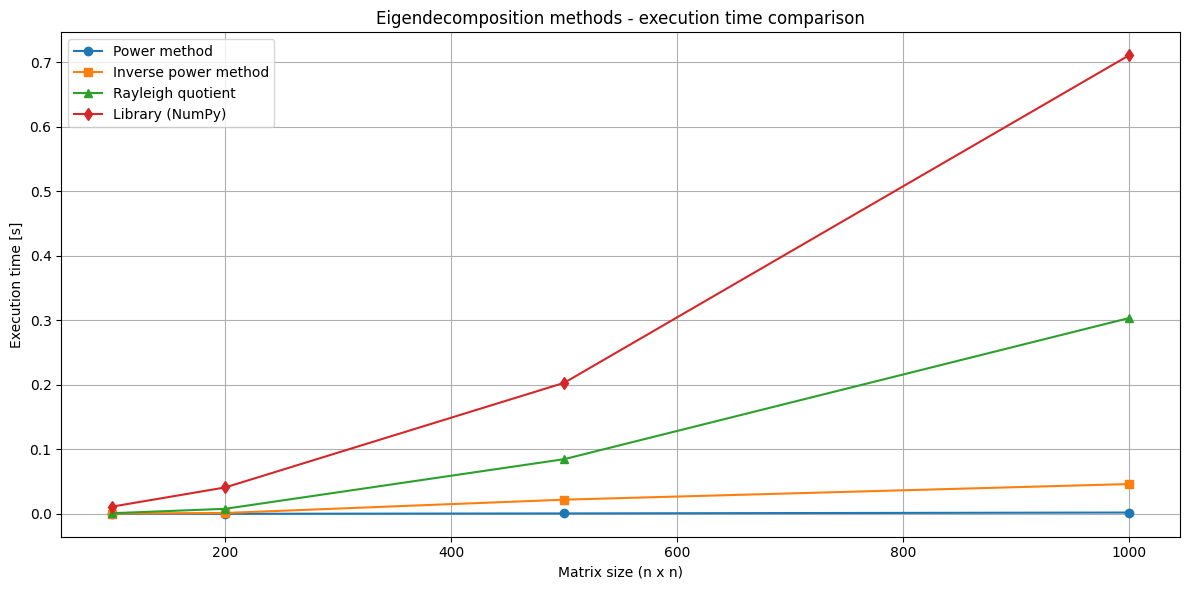

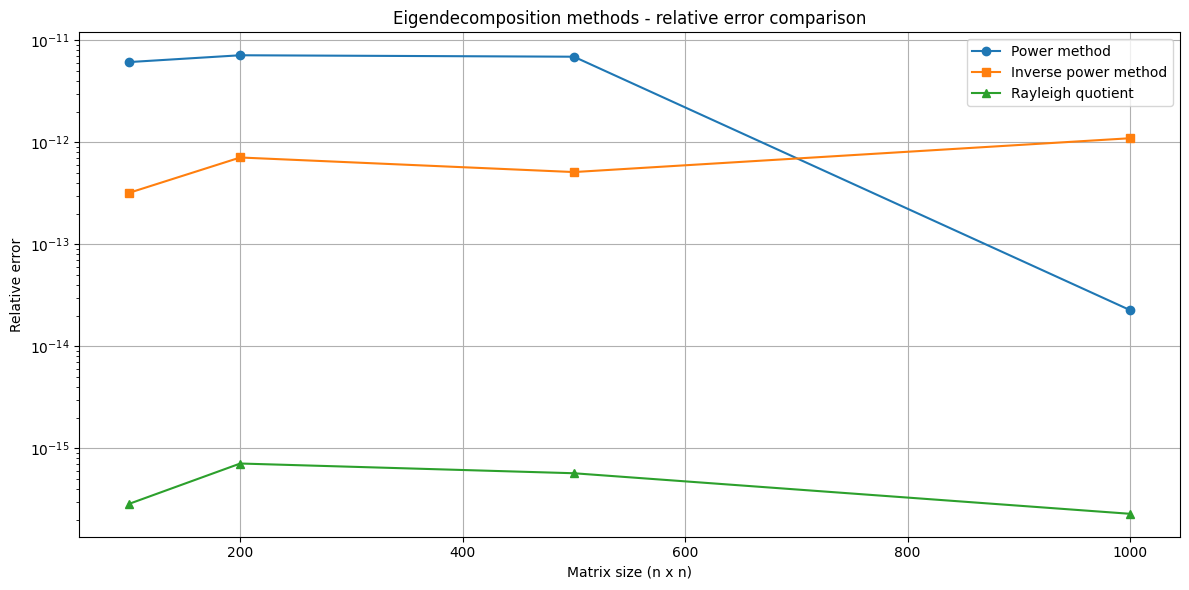

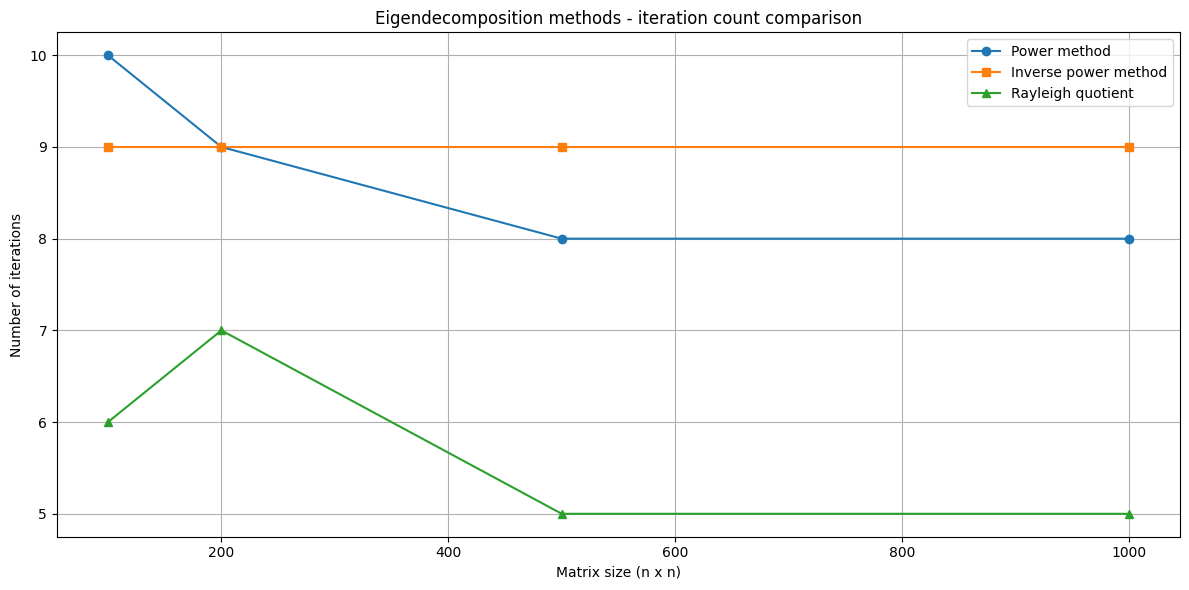

In [23]:
sizes = [100, 200, 500, 1000]
methods = ["power_method", "inverse_power_method", "rayleigh_quotient", "library"]

times = {method: [] for method in methods}
errors = {method: [] for method in methods if method != "library"}
iterations = {method: [] for method in methods if method != "library"}
all_results = []

print("\nBenchmarking eigendecomposition methods for different matrix sizes:")

for size in sizes:
    print(f"\nMatrix size: {size}x{size}")
    print("-" * (22 if size == 1000 else 20))

    A_ = np.random.rand(size, size)
    A_ = (A_ + A_.T) / 2

    results_ = compare_methods(A_)

    size_results = []
    for method in methods:
        times[method].append(results_[method]["time"])

        if method != "library":
            errors[method].append(results_[method]["rel_error_val"])
            iterations[method].append(results_[method]["iterations"])

            row = {
                "Matrix size": f"{size}x{size}",
                "Method": method.replace("_", " ").title(),
                "Eigenvalue": f"{results_[method]['eigenvalue']:.12f}",
                "Relative error": f"{results_[method]['rel_error_val']:.6e}",
                "Vector similarity": f"{results_[method]['vec_similarity']:.12f}",
                "Iterations": results_[method]["iterations"],
                "Time": f"{results_[method]['time']:.6f}s",
            }
            size_results.append(row)
        else:
            row = {
                "Matrix size": f"{size}x{size}",
                "Method": "Library (NumPy)",
                "Eigenvalue": f"{results_[method]['eigenvalue']:.12f}",
                "Relative error": "N/A",
                "Vector similarity": "N/A",
                "Iterations": "N/A",
                "Time": f"{results_[method]['time']:.6f}s",
            }
            size_results.append(row)

    df = pd.DataFrame(size_results)
    display(df)
    print("=" * 100)
    all_results.extend(size_results)

summary_df = pd.DataFrame(all_results)
print("\nSummary of all results:")
display(summary_df)

plot_benchmark(sizes, times, errors, iterations)